In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

Read in data.

In [2]:
ori_DNA_rep1 = pd.read_csv('counts_20230704/STARR_DNA_rep1_counts.txt', sep='\t', names=['sequence', 'count'])
ori_DNA_rep2 = pd.read_csv('counts_20230704/STARR_DNA_rep2_counts.txt', sep='\t', names=['sequence', 'count'])
ori_RNA_rep1 = pd.read_csv('counts_20230704/STARR_RNA_rep1_counts.txt', sep='\t', names=['sequence', 'count', 'collapsed_count'])
ori_RNA_rep2 = pd.read_csv('counts_20230704/STARR_RNA_rep2_counts.txt', sep='\t', names=['sequence', 'count', 'collapsed_count'])

Join RNA and DNA on sequences.

In [3]:
joined_DNA = ori_DNA_rep1.merge(ori_DNA_rep2, on='sequence', how='inner', suffixes=('_rep1', '_rep2'))
joined_RNA = ori_RNA_rep1.merge(ori_RNA_rep2, on='sequence', how='inner', suffixes=('_rep1', '_rep2'))
joined_counts = joined_DNA.merge(joined_RNA, on='sequence', how='inner', suffixes=('_DNA', '_RNA'))

Calculate normalized DNA counts, then normalize RNA counts by normalized DNA abundance.

In [4]:
joined_counts['cpm_DNA_1'] = (joined_counts['count_rep1_DNA']/joined_counts['count_rep1_DNA'].sum()) * 1e6
joined_counts['cpm_DNA_2'] = (joined_counts['count_rep2_DNA']/joined_counts['count_rep2_DNA'].sum()) * 1e6
joined_counts['log10_RNA_rep1_norm'] = np.log10((joined_counts['collapsed_count_rep1'] + 1) / joined_counts['cpm_DNA_1'])
joined_counts['log10_RNA_rep2_norm'] = np.log10((joined_counts['collapsed_count_rep2'] + 1) / joined_counts['cpm_DNA_2'])
joined_counts.head()

,sequence,count_rep1_DNA,count_rep2_DNA,count_rep1_RNA,collapsed_count_rep1,count_rep2_RNA,collapsed_count_rep2,cpm_DNA_1,cpm_DNA_2,log10_RNA_rep1_norm,log10_RNA_rep2_norm
0,GGTGTCGTGGTCGGTACAGGACTGTAAGGGTTGCGGTACTTCAGTG...,445,1012,1846,131,1011,82,27.385596,38.554655,0.683052,0.333001
1,AATGTTTTAGGCCAGTGCCATGGGGTATGAAGTGAGGGGAATTGGG...,424,614,4147,268,1982,167,26.093242,23.391856,1.013224,0.856245
2,GTGGCACGTGTGTGATGGGGTACATTAGTCACTTGAGGCCTGAAGA...,423,706,536,52,1701,150,26.031702,26.896824,0.308773,0.749276
3,AGGGGGTGGTACACTGTTTTAAGAAGCCCTGGGCAATTGTCTGACT...,422,791,2502,202,809,79,25.970161,30.135110,0.893021,0.424017
4,ATGTTCCACAGGATGTGGGTGCTGGGTGGTTCAGTTTGAGGCGATG...,416,822,1671,122,1967,142,25.600917,31.316132,0.681650,0.659568


In [5]:
joined_counts.describe()

,count_rep1_DNA,count_rep2_DNA,count_rep1_RNA,collapsed_count_rep1,count_rep2_RNA,collapsed_count_rep2,cpm_DNA_1,cpm_DNA_2,log10_RNA_rep1_norm,log10_RNA_rep2_norm
count,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000
mean,45.283563,73.148678,321.637133,26.572168,308.532632,26.698141,2.786781,2.786781,0.831593,0.926376
std,29.102870,48.418631,367.016176,27.046461,293.017864,23.188531,1.791010,1.844628,0.550546,0.392673
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.061541,0.038097,-0.936839,-0.890526
25%,25.000000,40.000000,17.000000,4.000000,113.000000,10.000000,1.538517,1.523899,0.418446,0.705070
50%,40.000000,63.000000,255.000000,21.000000,235.000000,21.000000,2.461627,2.400142,0.919353,0.969135
75%,59.000000,94.000000,465.000000,38.000000,431.000000,37.000000,3.630899,3.581164,1.232740,1.188655
max,445.000000,1012.000000,7680.000000,492.000000,10461.000000,649.000000,27.385596,38.554655,3.321428,3.118074


Look at correlation between replicates after normalization.

<AxesSubplot:xlabel='log10_RNA_rep1_norm', ylabel='log10_RNA_rep2_norm'>

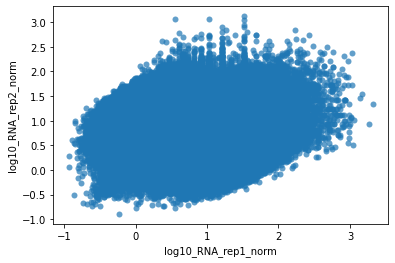

In [6]:
sns.scatterplot(data=joined_counts, x='log10_RNA_rep1_norm', y='log10_RNA_rep2_norm', linewidth=0, alpha=0.7)

In [7]:
cor = stats.pearsonr(joined_counts['log10_RNA_rep1_norm'], joined_counts['log10_RNA_rep2_norm'])
print(f'Pearson correlation: {cor[0]}')
print(f'p value: {cor[1]}')

Pearson correlation: 0.035024972533597376
p value: 8.553807585290121e-98


See if spike-in sequences are present.

In [8]:
spike_in = pd.read_csv('opoolsentry_spike_in.csv', names=['pool', 'sequence'])
spike_in['sequence'] = spike_in['sequence'].str.upper()
# remove adapter sequences
spike_in_seqs = [seq[33:133] for seq in spike_in['sequence']]
spike_in_seqs = set(spike_in_seqs)

In [9]:
joined_counts['spike_in'] = joined_counts['sequence'].isin(spike_in_seqs)
sum(joined_counts['spike_in'])

9

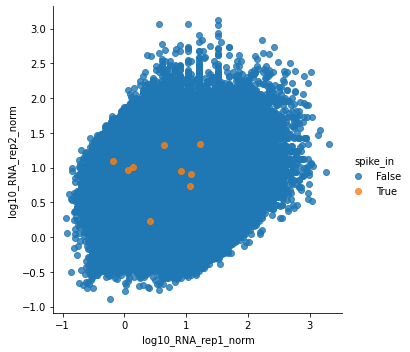

In [10]:
sns.lmplot(data=joined_counts, x="log10_RNA_rep1_norm", y="log10_RNA_rep2_norm", fit_reg=False, hue='spike_in')

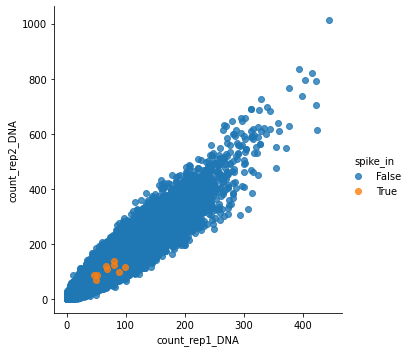

In [11]:
sns.lmplot(data=joined_counts, x="count_rep1_DNA", y="count_rep2_DNA", fit_reg=False, hue='spike_in')

Look for instances of motif in sequences

In [12]:
joined_counts['motif'] = joined_counts['sequence'].str.contains(r'[ACG]ATTT[AG]CAT[ACG]ACAAT[AG][ACG]')

<AxesSubplot:xlabel='log10_RNA_rep1_norm', ylabel='log10_RNA_rep2_norm'>

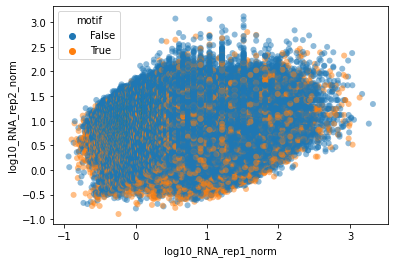

In [13]:
sns.scatterplot(data=joined_counts, x="log10_RNA_rep1_norm", y="log10_RNA_rep2_norm", hue='motif', linewidth=0, alpha=0.5)

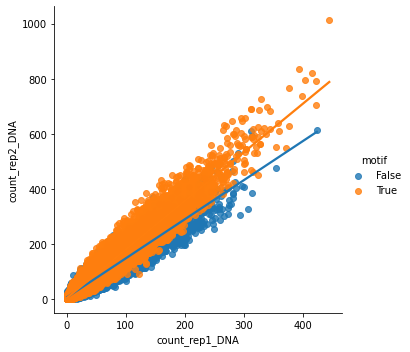

In [14]:
sns.lmplot(data=joined_counts, x="count_rep1_DNA", y="count_rep2_DNA", fit_reg=True, hue='motif')

See if sequences of different lengths are overrepresented in one DNA replicate.

In [15]:
joined_counts['length'] = joined_counts['sequence'].str.len()

(array([7.01900e+03, 6.13000e+02, 1.14200e+03, 2.97533e+05, 6.80000e+01,
        7.40000e+01, 8.00000e+01, 9.80000e+01, 1.45000e+02, 5.20650e+04]),
 array([ 83.,  88.,  93.,  98., 103., 108., 113., 118., 123., 128., 133.]),
 <BarContainer object of 10 artists>)

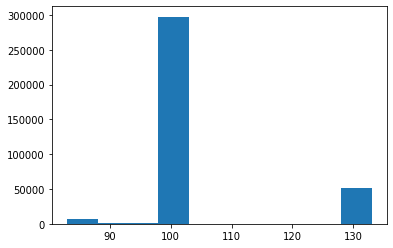

In [16]:
plt.hist(joined_counts['length'])

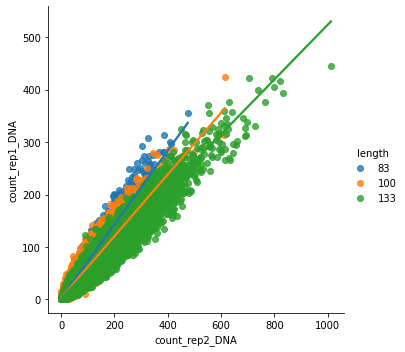

In [17]:
sns.lmplot(data=joined_counts, x="count_rep2_DNA", y="count_rep1_DNA", fit_reg=True, hue='length', hue_order=[83, 100, 133])

See if the random DNA library also contains the motif.

<AxesSubplot:xlabel='length', ylabel='Count'>

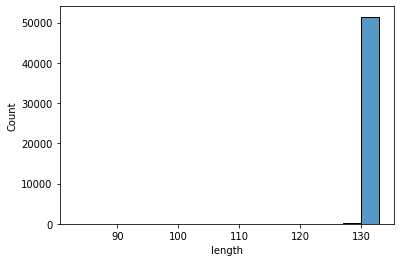

In [18]:
sns.histplot(joined_counts.loc[joined_counts['motif']]['length'])

<AxesSubplot:xlabel='length', ylabel='Count'>

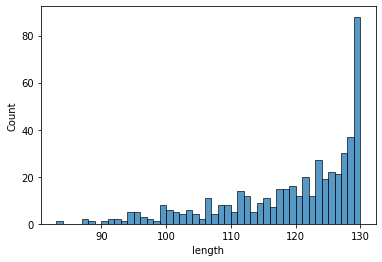

In [19]:
sns.histplot(joined_counts.loc[joined_counts['motif']]['length'], binrange=(83, 130), binwidth=1)

Add GC content column.

In [20]:
def GC_content(seq):
    return sum(base == 'G' or base == 'C' for base in seq) / len(seq)
assert GC_content('ATATATCGAT') == 0.2
assert GC_content('CGGCGTATAT') == 0.5

In [21]:
joined_counts['GC'] = joined_counts['sequence'].apply(GC_content)

Look at correlation between GC content and expression.

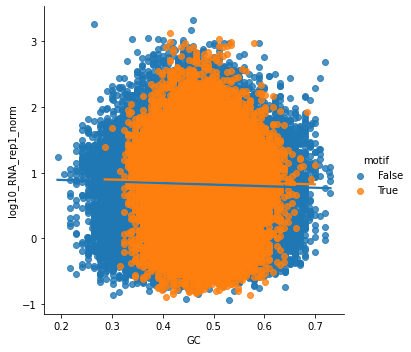

In [22]:
sns.lmplot(data=joined_counts, x="GC", y="log10_RNA_rep1_norm", fit_reg=True, hue='motif')

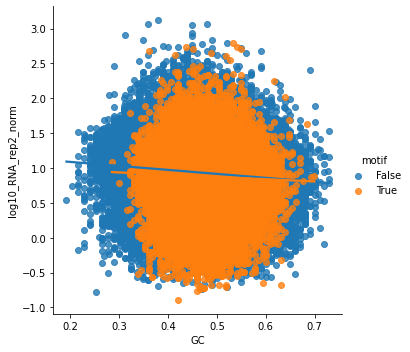

In [23]:
sns.lmplot(data=joined_counts, x="GC", y="log10_RNA_rep2_norm", fit_reg=True, hue='motif')

Filter out sequences with low RNA counts.

In [24]:
RNA_threshold = 20
DNA_threshold = 10
joined_counts_filtered = joined_counts.loc[(joined_counts['collapsed_count_rep1'] > RNA_threshold)
                                   & (joined_counts['collapsed_count_rep2'] > RNA_threshold)
                                   & (joined_counts['count_rep1_DNA'] > DNA_threshold)
                                   & (joined_counts['count_rep2_DNA'] > DNA_threshold)]
len(joined_counts_filtered)

99389

(array([2.5240e+03, 1.6900e+02, 3.0000e+02, 7.7088e+04, 1.7000e+01,
        2.7000e+01, 2.4000e+01, 2.9000e+01, 5.2000e+01, 1.9159e+04]),
 array([ 83.,  88.,  93.,  98., 103., 108., 113., 118., 123., 128., 133.]),
 <BarContainer object of 10 artists>)

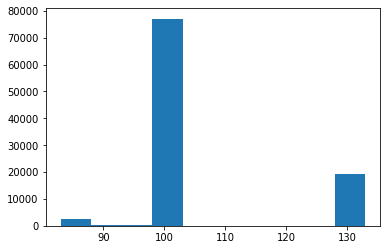

In [36]:
plt.hist(joined_counts_filtered['length'])

<AxesSubplot:xlabel='log10_RNA_rep1_norm', ylabel='log10_RNA_rep2_norm'>

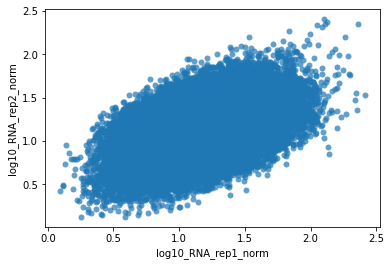

In [25]:
sns.scatterplot(data=joined_counts_filtered, x='log10_RNA_rep1_norm', y='log10_RNA_rep2_norm', linewidth=0, alpha=0.7)

Look at correlation with and without DNA normalization.

With DNA normalization:

In [26]:
stats.pearsonr(joined_counts_filtered['log10_RNA_rep1_norm'], joined_counts_filtered['log10_RNA_rep2_norm'])

(0.4517108602897929, 0.0)

Without DNA normalization:

In [27]:
stats.pearsonr(np.log10(joined_counts_filtered['collapsed_count_rep1']), np.log10(joined_counts_filtered['collapsed_count_rep2']))

(0.23451515394853606, 0.0)

See if motif-containing sequences have different expression than non-motif.

<AxesSubplot:xlabel='log10_RNA_rep1_norm', ylabel='log10_RNA_rep2_norm'>

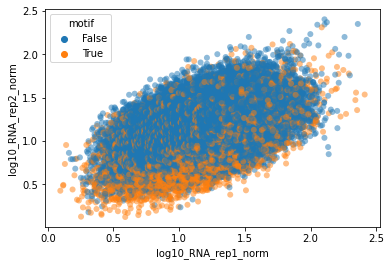

In [28]:
sns.scatterplot(data=joined_counts_filtered, x="log10_RNA_rep1_norm", y="log10_RNA_rep2_norm", hue='motif', linewidth=0, alpha=0.5)

<AxesSubplot:xlabel='motif', ylabel='log10_RNA_rep1_norm'>

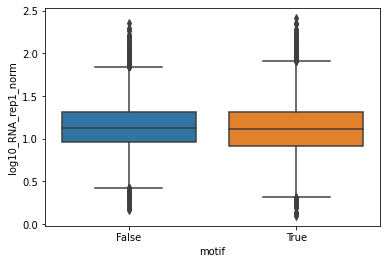

In [29]:
sns.boxplot(data=joined_counts_filtered, x='motif', y='log10_RNA_rep1_norm')

<AxesSubplot:xlabel='motif', ylabel='log10_RNA_rep2_norm'>

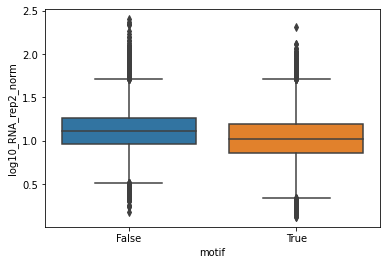

In [30]:
sns.boxplot(data=joined_counts_filtered, x='motif', y='log10_RNA_rep2_norm')

See if GC has an effect on expression for motif and non-motif.

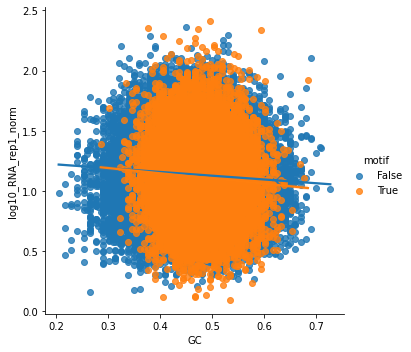

In [31]:
sns.lmplot(data=joined_counts_filtered, x="GC", y="log10_RNA_rep1_norm", fit_reg=True, hue='motif')

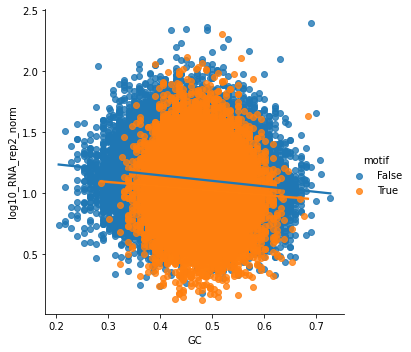

In [32]:
sns.lmplot(data=joined_counts_filtered, x="GC", y="log10_RNA_rep2_norm", fit_reg=True, hue='motif')

Look at difference in expression between different libraries.

<AxesSubplot:xlabel='length', ylabel='log10_RNA_rep1_norm'>

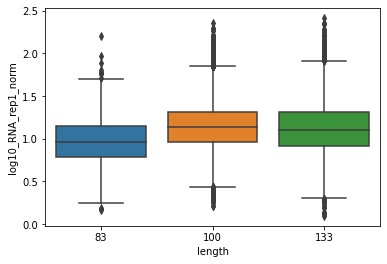

In [33]:
sns.boxplot(data=joined_counts_filtered, y="log10_RNA_rep1_norm", x="length", order=[83, 100, 133])

<AxesSubplot:xlabel='length', ylabel='log10_RNA_rep2_norm'>

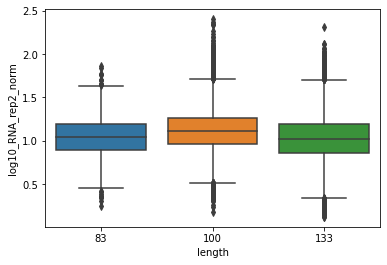

In [34]:
sns.boxplot(data=joined_counts_filtered, y="log10_RNA_rep2_norm", x="length", order=[83, 100, 133])

Look at correlation between normalized RNA for each library length.

In [35]:
lengths = [83, 100, 133]
cols_to_cor = ['log10_RNA_rep1_norm', 'log10_RNA_rep2_norm']
filtered_df = joined_counts_filtered[joined_counts_filtered['length'].isin(lengths)]
correlation_df = filtered_df.groupby('length')[cols_to_cor].corr()
correlation_df

log10_RNA_rep1_norm  log10_RNA_rep2_norm
length                                                              
83     log10_RNA_rep1_norm             1.000000             0.374051
       log10_RNA_rep2_norm             0.374051             1.000000
100    log10_RNA_rep1_norm             1.000000             0.433790
       log10_RNA_rep2_norm             0.433790             1.000000
133    log10_RNA_rep1_norm             1.000000             0.508817
       log10_RNA_rep2_norm             0.508817             1.000000